#

Kernel SHAP (SHapley Additive exPlanations) values are a unified measure of feature importance that allocates the contribution of each feature to the prediction for a specific instance. They are based on the concept of Shapley values from cooperative game theory.

In the context of a regression problem, the interpretation of Kernel SHAP values is as follows:

- **Magnitude**: The magnitude of a SHAP value for a feature indicates the degree to which that feature affects the prediction. A larger absolute SHAP value means that the feature has a stronger impact on the output. The units of these values are in the output units of the model.

- **Sign**: The sign of a SHAP value indicates the direction of the effect. A positive SHAP value for a feature indicates that the presence of that feature increases the model's output, while a negative SHAP value indicates that the presence of that feature decreases the model's output.

- **Zero**: A SHAP value of zero for a feature indicates that the feature did not contribute to the prediction for that specific instance.

It's important to note that SHAP values are instance-specific. They tell you how much each feature contributed to the prediction for a specific instance, not how much each feature contributes to the model's predictions in general. For a general measure of feature importance, you would need to calculate SHAP values for many instances and then aggregate them in some way.


In [11]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import dianna

from pathlib import Path
from joblib import load
from matplotlib import pyplot as plt
from dianna import visualization
from dianna.utils.onnx_runner import SimpleModelRunner
from IPython.display import display
from sklearn.model_selection import train_test_split

np.random.seed(0)
root_dir = Path(dianna.__file__).parent

In [3]:
## TODO Colab setup

In [7]:
## TODO
# Download model from zenodo
parent_in_path = "/home/sarah/temp/ecoextreml/emulator_data/model"
model_path = f"{parent_in_path}/model_LEtot.onnx" # trained on one year of data

In [5]:
def preprocess(data):
    data_reshaped = data
    if len(data.shape) == 1:
        data_reshaped = data.reshape(1,-1)
    return data_reshaped.astype(np.float32)
    
runner = SimpleModelRunner(model_path, preprocess_function=preprocess)

In [72]:
model_input_path = "/home/sarah/temp/ecoextreml/emulator_data/model/training_testing_2014_prepared.csv"
model_input = pd.read_csv(model_input_path)
model_input

,Unnamed: 0,station,date_UTC,Precip_msr,Rin,Rli,p,Ta,ea,u,...,IGBP_veg_long2,IGBP_veg_long3,IGBP_veg_long4,IGBP_veg_long5,IGBP_veg_long6,IGBP_veg_long7,IGBP_veg_long8,IGBP_veg_long9,IGBP_veg_long10,IGBP_veg_long11
0,0,AU-ASM,2013-12-31 15:00:00,0.0,0.000000,422.350995,940.534220,31.677529,0.087688,2.134386,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,AU-ASM,2013-12-31 16:00:00,0.0,0.000000,405.639800,932.560705,31.299402,0.099312,1.201066,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,AU-ASM,2013-12-31 17:00:00,0.0,0.000000,413.726000,939.196055,30.007821,0.107478,1.354100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,AU-ASM,2013-12-31 18:00:00,0.0,0.000000,412.545700,940.048085,30.011499,0.110519,1.795051,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,AU-ASM,2013-12-31 19:00:00,0.0,0.000000,381.210585,940.882070,29.375940,0.112046,1.729858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136583,138385,US-Myb,2014-03-14 22:00:00,0.0,691.839510,315.739010,1023.000000,20.380014,10.184294,2.369500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136584,138386,US-Myb,2014-03-14 23:00:00,0.0,536.578495,315.739010,1022.500000,21.415002,10.509555,1.799000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136585,138387,US-Myb,2014-03-15 00:00:00,0.0,346.486005,309.051010,1022.200000,22.374994,10.878103,1.528500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136586,138388,US-Myb,2014-03-15 01:00:00,0.0,150.326500,302.363010,1022.150000,22.409997,10.705077,1.653500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [92]:
# test, train data
x_vars = ['station', 'date_UTC', 'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI','Vcmo', 'hc', 'Precip_msr','SSM', *[f'IGBP_veg_long{i}' for i in range(1, 12)]]
x = model_input[x_vars]

y_vars = ['station', 'date_UTC', 'LEtot']
y = model_input[y_vars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, shuffle=True)

In [74]:
features = x_test.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()
data_instance = features[0, :].reshape(1, -1)
background_data = np.zeros(data_instance.shape)  # it should be `x_train` but it is slower

In [75]:
%%time
explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                     feature_names=input_vars)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2.4 s, sys: 29.2 ms, total: 2.43 s
Wall time: 1.45 s


In [76]:
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

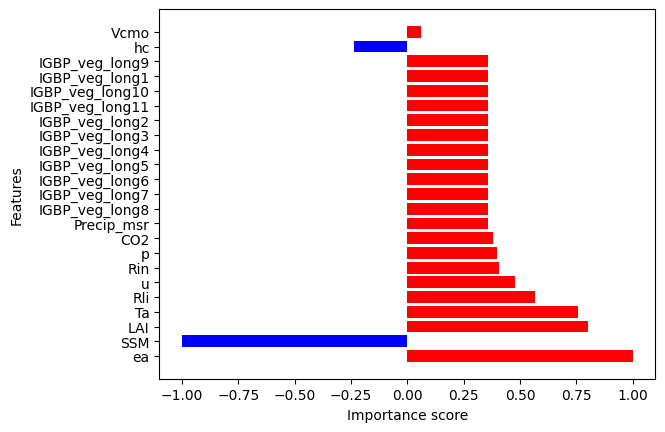

In [77]:
heat_map = normalize(explanation)[0]
_ = visualization.plot_tabular(heat_map, input_vars, num_features=len(input_vars))

In [116]:
# loop over time series at one location
x_test_time = x_test[x_test["station"] == "US-Myb"]
features = x_test_time.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [81]:
explanations = np.zeros(features.shape)
for time in range(features.shape[0]):
    data_instance = features[time].reshape(1, -1)
    background_data = np.zeros(data_instance.shape)
    explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                    feature_names=input_vars, silent=True)
    explanations[time] = normalize(explanation)

print("Dianna is done!") 

Dianna is done!


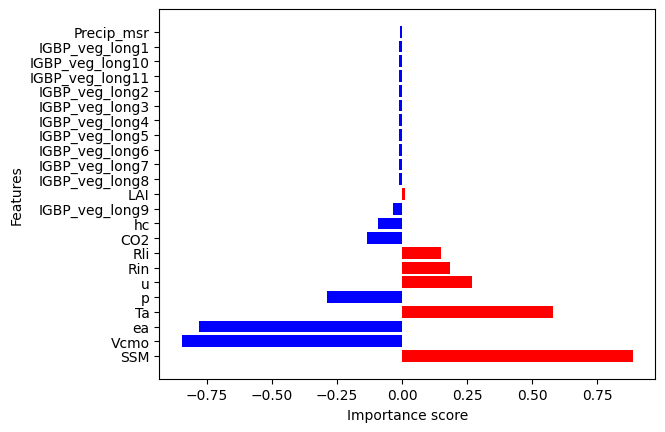

In [83]:
heat_map = explanations.mean(axis=0) 
_ = visualization.plot_tabular(heat_map, input_vars, num_features=len(input_vars))

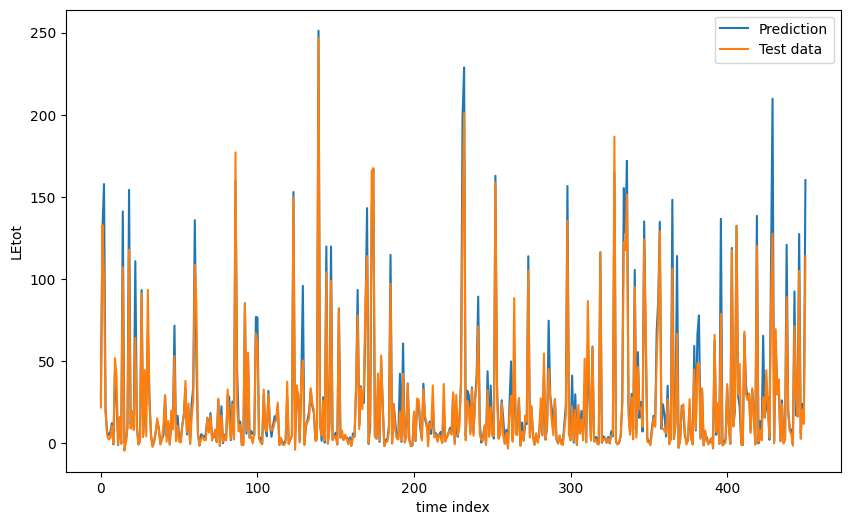

In [119]:
import matplotlib.pyplot as plt

y_predict_time = runner(features)
y_test_time = y_test[y_test["station"] == "US-Myb"].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_predict_time, label='Prediction')
plt.plot(y_test_time, label='Test data')

plt.xlabel('time index')
plt.ylabel('LEtot')
plt.legend()

plt.show()

In [114]:
# loop over all location at one time
x_test_space = x_test[x_test["date_UTC"] == "2014-04-28 09:00:00"]
features = x_test_space.drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

In [88]:
explanations = np.zeros(features.shape)
for location in range(features.shape[0]):
    data_instance = features[location].reshape(1, -1)
    background_data = np.zeros(data_instance.shape)
    explanation = dianna.explain_tabular(runner, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data=background_data, 
                                    feature_names=input_vars, silent=True)
    explanations[location] = normalize(explanation)

print("Dianna is done!") 

Dianna is done!


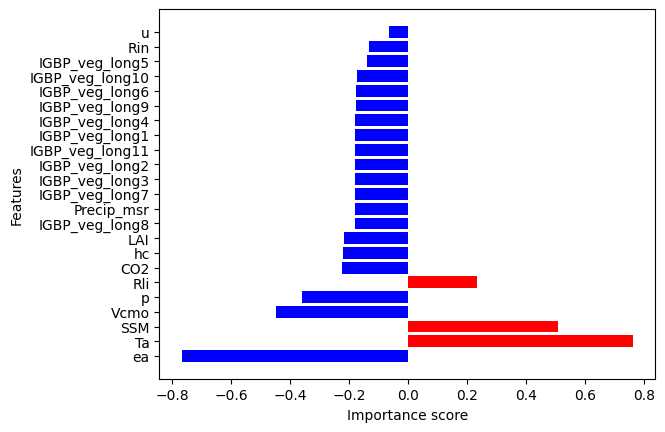

In [89]:
heat_map = explanations.mean(axis=0)
_ = visualization.plot_tabular(heat_map, input_vars, num_features=len(input_vars))

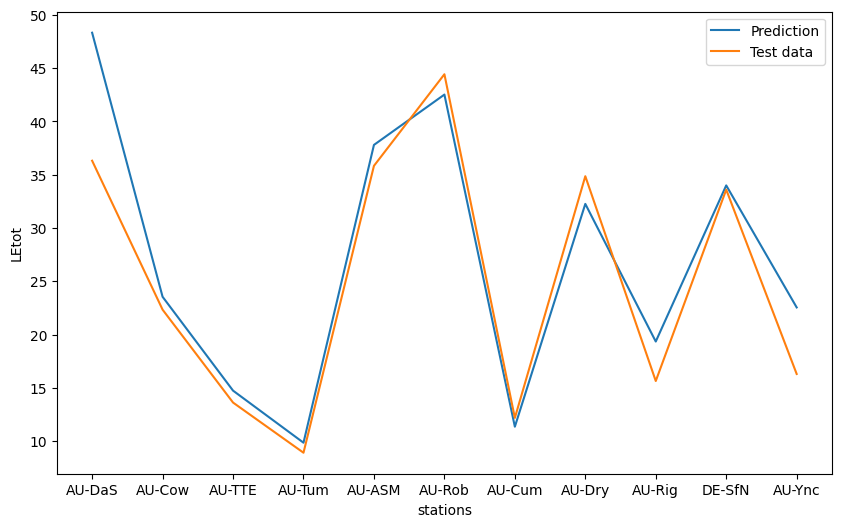

In [115]:
import matplotlib.pyplot as plt

y_predict_space = runner(features)
y_test_space = y_test[y_test["date_UTC"] == "2014-04-28 09:00:00"].drop(columns=['station', 'date_UTC']).fillna(0).to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(x_test_space["station"], y_predict_space, label='Prediction')
plt.plot(y_test_space, label='Test data')

plt.xlabel('stations')
plt.ylabel('LEtot')
plt.legend()

plt.show()